<a href="https://colab.research.google.com/github/tirtha0809/Machine-Learning/blob/main/Asid_DA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as kf
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score,roc_curve,auc
from statistics import mean
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing DataSet

In [3]:
data = pd.read_csv('/content/drive/MyDrive/LANDSLIDE/LandslideData .csv')
dataset = data.dropna(axis = 0, how ='any')
X =  dataset.iloc[:,1:-1].values
y = dataset.iloc[:, -1].values
print(len(dataset))

3991


In [4]:
#smote = SMOTE()

In [5]:
#x_smote, y_smote = smote.fit_resample(X, y)
smote= SMOTE(k_neighbors = 3)
x_smote,y_smote = smote.fit_resample(X,y)

In [6]:
from keras.models import load_model

In [7]:
# create a custom function to load model
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # filename
        filename = 'north/model' + str(i + 1) + '.h5'
        # load model
        model = load_model(filename)
        # Add a list of all the weaker learners
        all_models.append(model)
        #print('>loaded %s' % filename)
    return all_models

## Stacking models

In [8]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat #
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

## Fit meta-learner

In [9]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    #print("Models Test time: ",(end-start) * 10**3, "ms")
    # fit the meta learner
    # model = LogisticRegression() #meta learner
    # model = SVC(kernel = 'rbf',random_state = 0,probability= True)
    #model = SVC(kernel = 'linear', random_state = 0,probability=True)
    # model = GaussianNB()
    #model = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
    # model = GradientBoostingClassifier(n_estimators=50,learning_rate=0.5, max_depth=6, random_state=0)
    model = RandomForestClassifier(criterion = 'entropy', random_state = 0)
    #model = DecisionTreeClassifier(max_depth=7,criterion = 'entropy', random_state = 0)
    # model = XGBClassifier(n_estimators=50,learning_rate=0.5,max_depth=3)
    #model = AdaBoostClassifier(random_state = 0)
    # model = AdaBoostClassifier(n_estimators = 300, learning_rate = 1,random_state = 0)
    #model.fit(X_train, y_train)
    model.fit(stackedX, inputy)
    return model

In [10]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [11]:
def stacked_prediction_proba(members,model,inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members,inputX)
    # make a prediction
    yhatProb = model.predict_proba(stackedX)
    return yhatProb

In [12]:
acc_train = []
acc_test = []
Precision_macro = []
Precision_micro = []
Recall_macro = []
Recall_micro = []
F1_macro = []
F1_micro = []
AUC_ovo = []
AUC_ovr = []
train_time = []
test_time = []

In [13]:
num_classes = 15

In [14]:
for i in range(5):
    X_train_val, X_test_cv, y_train_val, y_test_cv = train_test_split(x_smote, y_smote, test_size=0.25, random_state=i)
    X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=i)
    y_train_cv = y_train_cv - 1
    y_val_cv = y_val_cv - 1
    y_test_cv = y_test_cv - 1

    sc = StandardScaler()
    X_train_cv = sc.fit_transform(X_train_cv)
    X_val_cv = sc.transform(X_val_cv)
    X_test_cv = sc.transform(X_test_cv)
    unique_labels = np.unique(y_train_cv)
    print(unique_labels)

    start = time.time()
    # Model 1
    ann1 = Sequential()
    ann1.add(tf.keras.layers.Dense(units=10, activation='relu'))
    ann1.add(tf.keras.layers.Dense(units=10, activation='relu'))
    ann1.add(tf.keras.layers.Dense(units=10, activation='relu'))
    ann1.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann1.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann1.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 2
    ann2 = Sequential()
    ann2.add(tf.keras.layers.Dense(units=20, activation='relu'))
    ann2.add(tf.keras.layers.Dense(units=20, activation='relu'))
    ann2.add(tf.keras.layers.Dense(units=20, activation='relu'))
    ann2.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann2.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann2.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 3
    ann3 = Sequential()
    ann3.add(tf.keras.layers.Dense(units=30, activation='relu'))
    ann3.add(tf.keras.layers.Dense(units=30, activation='relu'))
    ann3.add(tf.keras.layers.Dense(units=30, activation='relu'))
    ann3.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann3.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann3.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 4

    ann4 = Sequential()
    ann4.add(tf.keras.layers.Dense(units=40, activation='relu'))
    ann4.add(tf.keras.layers.Dense(units=40, activation='relu'))
    ann4.add(tf.keras.layers.Dense(units=40, activation='relu'))
    ann4.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann4.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann4.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 5

    ann5 = Sequential()
    ann5.add(tf.keras.layers.Dense(units=15, activation='relu'))
    ann5.add(tf.keras.layers.Dense(units=15, activation='relu'))
    ann5.add(tf.keras.layers.Dense(units=15, activation='relu'))
    ann5.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann5.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann5.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 6

    ann6 = Sequential()
    ann6.add(tf.keras.layers.Dense(units=25, activation='relu'))
    ann6.add(tf.keras.layers.Dense(units=25, activation='relu'))
    ann6.add(tf.keras.layers.Dense(units=25, activation='relu'))
    ann6.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann6.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann6.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 7

    ann7 = Sequential()
    ann7.add(tf.keras.layers.Dense(units=35, activation='relu'))
    ann7.add(tf.keras.layers.Dense(units=35, activation='relu'))
    ann7.add(tf.keras.layers.Dense(units=35, activation='relu'))
    ann7.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann7.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann7.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 8

    ann8 = Sequential()
    ann8.add(tf.keras.layers.Dense(units=45, activation='relu'))
    ann8.add(tf.keras.layers.Dense(units=45, activation='relu'))
    ann8.add(tf.keras.layers.Dense(units=45, activation='relu'))
    ann8.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann8.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann8.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 100,verbose=0)

    # Model 9

    ann9 = Sequential()
    ann9.add(tf.keras.layers.Dense(units=50, activation='relu'))
    ann9.add(tf.keras.layers.Dense(units=50, activation='relu'))
    ann9.add(tf.keras.layers.Dense(units=50, activation='relu'))
    ann9.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann9.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann9.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    # Model 10

    ann10 = Sequential()
    ann10.add(tf.keras.layers.Dense(units=60, activation='relu'))
    ann10.add(tf.keras.layers.Dense(units=60, activation='relu'))
    ann10.add(tf.keras.layers.Dense(units=60, activation='relu'))
    ann10.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann10.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann10.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)
    # Model 11

    ann11 = Sequential()
    ann11.add(tf.keras.layers.Dense(units=70, activation='relu'))
    ann11.add(tf.keras.layers.Dense(units=70, activation='relu'))
    ann11.add(tf.keras.layers.Dense(units=70, activation='relu'))
    ann11.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann11.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann11.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    # Model 12

    ann12 = Sequential()
    ann12.add(tf.keras.layers.Dense(units=80, activation='relu'))
    ann12.add(tf.keras.layers.Dense(units=80, activation='relu'))
    ann12.add(tf.keras.layers.Dense(units=80, activation='relu'))
    ann12.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann12.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann12.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    # Model 13

    ann13 = Sequential()
    ann13.add(tf.keras.layers.Dense(units=55, activation='relu'))
    ann13.add(tf.keras.layers.Dense(units=55, activation='relu'))
    ann13.add(tf.keras.layers.Dense(units=55, activation='relu'))
    ann13.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann13.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann13.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    # Model 14

    ann14 = Sequential()
    ann14.add(tf.keras.layers.Dense(units=65, activation='relu'))
    ann14.add(tf.keras.layers.Dense(units=65, activation='relu'))
    ann14.add(tf.keras.layers.Dense(units=65, activation='relu'))
    ann14.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann14.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann14.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    # Model 15

    ann15 = Sequential()
    ann15.add(tf.keras.layers.Dense(units=75, activation='relu'))
    ann15.add(tf.keras.layers.Dense(units=75, activation='relu'))
    ann15.add(tf.keras.layers.Dense(units=75, activation='relu'))
    ann15.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann15.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann15.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    # Model 16

    ann16 = Sequential()
    ann16.add(tf.keras.layers.Dense(units=85, activation='relu'))
    ann16.add(tf.keras.layers.Dense(units=85, activation= 'relu'))
    ann16.add(tf.keras.layers.Dense(units=85, activation='relu'))
    ann16.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
    ann16.compile(optimizer = 'adam', loss = kf.losses.SparseCategoricalCrossentropy(), metrics = [kf.metrics.CategoricalAccuracy()])
    ann16.fit(X_train_cv, y_train_cv, batch_size = 128, epochs = 150,verbose=0)

    ann1.save('north/model1.h5')
    ann2.save('north/model2.h5')
    ann3.save('north/model3.h5')
    ann4.save('north/model4.h5')
    ann5.save('north/model5.h5')
    ann6.save('north/model6.h5')
    ann7.save('north/model7.h5')
    ann8.save('north/model8.h5')
    ann9.save('north/model9.h5')
    ann10.save('north/model10.h5')
    ann11.save('north/model11.h5')
    ann12.save('north/model12.h5')
    ann13.save('north/model13.h5')
    ann14.save('north/model14.h5')
    ann15.save('north/model15.h5')
    ann16.save('north/model16.h5')

    members = load_all_models(16)
    model = fit_stacked_model(members, X_train_cv,y_train_cv)
    end = time.time()
    print("Cross validation Train time: ",(end-start) * 10**3, "ms")
    t = (end-start)*1000
    train_time.append(t)

    start = time.time()
    y_pred = stacked_prediction(members, model, X_test_cv)
    end = time.time()

    t = (end - start)*1000
    test_time.append(t)

    print("Cross validation Test time: ",(end-start) * 10**3, "ms")
    y_test_prob = stacked_prediction_proba(members,model,X_test_cv)
    y_train_pred = stacked_prediction(members, model, X_train_cv)

    cm = confusion_matrix(y_test_cv, y_pred)


    accuracy = accuracy_score(y_test_cv, y_pred)
    acc_test.append(accuracy)
    accuracy_train = accuracy_score(y_train_cv, y_train_pred)
    acc_train.append(accuracy_train)

    pre_macro = precision_score(y_test_cv, y_pred,average='macro')
    Precision_macro.append(pre_macro)
    pre_micro = precision_score(y_test_cv, y_pred,average='micro')
    Precision_micro.append(pre_micro)

    re_macro = recall_score(y_test_cv, y_pred,average='macro')
    Recall_macro.append(re_macro)
    re_micro = recall_score(y_test_cv, y_pred,average='micro')
    Recall_micro.append(re_micro)

    f1_macro = f1_score(y_test_cv, y_pred,average='macro')
    F1_macro.append(f1_macro)
    f1_micro = f1_score(y_test_cv, y_pred,average='micro')
    F1_micro.append(f1_micro)

    auc_ovo = roc_auc_score(y_test_cv,y_test_prob,multi_class='ovo')
    AUC_ovo.append(auc_ovo)
    auc_ovr = roc_auc_score(y_test_cv,y_test_prob,multi_class='ovr')
    AUC_ovr.append(auc_ovr)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


Cross validation Train time:  617565.0389194489 ms
Cross validation Test time:  11778.272867202759 ms
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


Cross validation Train time:  575883.3909034729 ms
Cross validation Test time:  8925.503969192505 ms
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


Cross validation Train time:  584811.1629486084 ms
Cross validation Test time:  9169.7838306427 ms
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


Cross validation Train time:  578101.2814044952 ms
Cross validation Test time:  8695.40023803711 ms
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


Cross validation Train time:  576795.9222793579 ms
Cross validation Test time:  8687.67523765564 ms


In [15]:
result_cv = pd.DataFrame()
result_cv["Train_acc"] = acc_train
result_cv["Test_acc"] = acc_test
result_cv["Precision(macro)"] = Precision_macro
result_cv["Precision(micro)"] = Precision_micro
result_cv["Recall(macro)"] = Recall_macro
result_cv["Recall(micro)"] = Recall_micro
result_cv["F1(macro)"] = F1_macro
result_cv["F1(micro)"] = F1_micro
result_cv["AUC(ovo)"] = AUC_ovo
result_cv["AUC(ovr)"] = AUC_ovr
result_cv["Train Time"] = train_time
result_cv["Test Time"] = test_time

In [16]:
train_time

[617565.0389194489,
 575883.3909034729,
 584811.1629486084,
 578101.2814044952,
 576795.9222793579]

In [17]:
test_time

[11778.272867202759,
 8925.503969192505,
 9169.7838306427,
 8695.40023803711,
 8687.67523765564]

In [18]:
result_cv.to_csv("filename", index=False)

In [19]:
result_cv_avg = pd.DataFrame()
lst = []
x = mean(acc_train)*100
lst.append(x)
result_cv_avg["Train_acc"] = lst
result_cv_avg["Test_acc"] = mean(acc_test)*100
result_cv_avg["SD"] = np.std(acc_test)*100
result_cv_avg["Precision(macro)"] = mean(Precision_macro)
result_cv_avg["Precision(micro)"] = mean(Precision_micro)
result_cv_avg["Recall(macro)"] = mean(Recall_macro)
result_cv_avg["Recall(micro)"] = mean(Recall_micro)
result_cv_avg["F1(macro)"] = mean(F1_macro)
result_cv_avg["F1(micro)"] = mean(F1_micro)
result_cv_avg["AUC(ovo)"] = mean(AUC_ovo)
result_cv_avg["AUC(ovr)"] = mean(AUC_ovr)

In [20]:
result_cv_avg.to_csv("filename", index=False)

In [21]:
acc_train

[0.9996676636756398,
 0.9994017946161515,
 0.9995347291458957,
 0.9994682618810236,
 0.9996676636756398]

In [22]:
acc_test

[0.9280693883654852,
 0.936593390160012,
 0.9349484073575595,
 0.9361447584866158,
 0.9358456707043518]

In [23]:
Precision_macro

[0.9237874070952937,
 0.9339013794284932,
 0.9298765137720085,
 0.9348647874812838,
 0.9330808939948927]

In [24]:
Precision_micro

[0.9280693883654852,
 0.936593390160012,
 0.9349484073575595,
 0.9361447584866158,
 0.9358456707043518]

In [25]:
Recall_macro

[0.9278095843503954,
 0.9369430750190929,
 0.9328192290771552,
 0.9374932123973458,
 0.9349724216636984]

In [26]:
Recall_micro

[0.9280693883654852,
 0.936593390160012,
 0.9349484073575595,
 0.9361447584866158,
 0.9358456707043518]

In [27]:
F1_macro

[0.9252464785090431,
 0.9349287780728067,
 0.9310783434890698,
 0.9358661386538056,
 0.9338324964026188]

In [28]:
F1_micro

[0.9280693883654852,
 0.936593390160012,
 0.9349484073575595,
 0.9361447584866158,
 0.9358456707043518]

In [29]:
AUC_ovo

[0.9931090145641117,
 0.9944394667045542,
 0.9926430008188497,
 0.9940758320301255,
 0.9939418794248371]

In [30]:
index = np.argmax(AUC_ovo)
print(index)

1


In [31]:
AUC_ovr

[0.993154784267801,
 0.9944412632589396,
 0.9928302587672354,
 0.993991185467952,
 0.9940063584453642]

In [32]:
 print("Accuracy(Train): {:.2f} %".format(mean(acc_train)*100))
print("Accuracy(Test): {:.2f} %".format(mean(acc_test)*100))
print("Standard Deviation: {:.2f}%".format(np.std(acc_test)*100))
print("Precision (macro): %.3f" %mean(Precision_macro))
print("Precision (micro): %.3f" %mean(Precision_micro))
print("Recall (macro): %.3f" %mean(Recall_macro))
print("Recall (micro): %.3f" %mean(Recall_micro))
print("F1 (macro): %.3f" %mean(F1_macro))
print("F1 (micro): %.3f" %mean(F1_micro))
print("AUC (ovo): %.3f" %mean(AUC_ovo))
print("AUC (ovr): %.3f" %mean(AUC_ovr))

Accuracy(Train): 99.95 %
Accuracy(Test): 93.43 %
Standard Deviation: 0.32%
Precision (macro): 0.931
Precision (micro): 0.934
Recall (macro): 0.934
Recall (micro): 0.934
F1 (macro): 0.932
F1 (micro): 0.934
AUC (ovo): 0.994
AUC (ovr): 0.994


In [33]:
from numpy import interp

In [34]:
actual_classes = y_test_cv
predicted_proba = y_test_prob

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=12
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(actual_classes))[:, i], np.array(predicted_proba)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#     print("fpr: ",fpr[i])
#     print("tpr: ",tpr[i])
#     print("roc_auc: ",roc_auc[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
print("all_fpr: ",all_fpr)
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print("mean_tpr: ",mean_tpr)
print("AUC = ",roc_auc['macro'])

all_fpr:  [0.00000000e+00 1.62654522e-04 1.62786912e-04 1.63371998e-04
 3.25309044e-04 3.25520833e-04 3.25573824e-04 3.25998370e-04
 3.26104680e-04 3.26424025e-04 3.26743996e-04 3.26850793e-04
 4.87963565e-04 4.88281250e-04 4.89396411e-04 4.89636037e-04
 4.90115994e-04 6.49034561e-04 6.50618087e-04 6.51041667e-04
 6.51996740e-04 6.52209359e-04 6.52848050e-04 6.53487992e-04
 6.53701585e-04 8.13272609e-04 8.13802083e-04 8.15261699e-04
 8.16060062e-04 8.16859990e-04 8.19403474e-04 8.20748523e-04
 9.73551842e-04 9.75927131e-04 9.76562500e-04 9.78792822e-04
 9.79272074e-04 1.13858165e-03 1.13932292e-03 1.14136638e-03
 1.14397777e-03 1.14904793e-03 1.30123617e-03 1.30208333e-03
 1.30505710e-03 1.30697598e-03 1.31319764e-03 1.46032776e-03
 1.46508221e-03 1.46890811e-03 1.47082857e-03 1.47492625e-03
 1.62654522e-03 1.62760417e-03 1.63132137e-03 1.63212012e-03
 1.78919974e-03 1.79036458e-03 1.79065603e-03 1.79445351e-03
 1.79709198e-03 1.80268764e-03 1.95185426e-03 1.95599022e-03
 1.95662808e-0

In [35]:
roc_csv = pd.DataFrame()
roc_csv["FPR(Macro)"] = all_fpr
roc_csv["TPR(Macro)"] = mean_tpr

In [36]:
roc_csv.to_csv("filename", index=False)

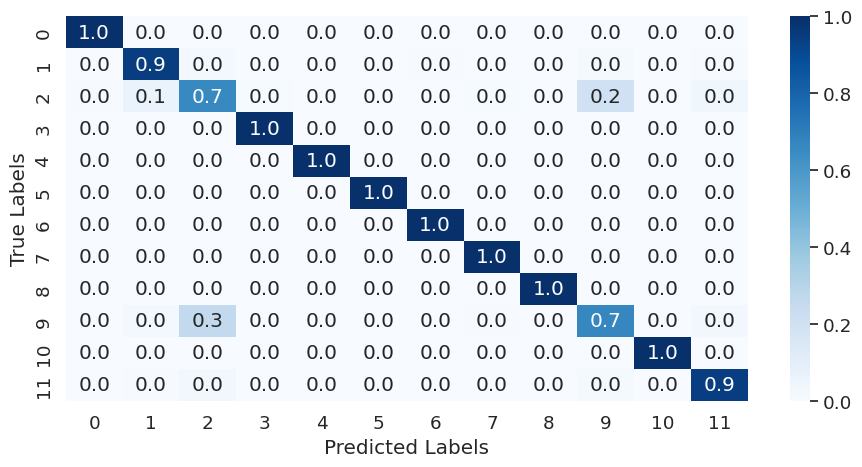

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assuming you have already calculated the confusion matrix 'cm' for 14 classes

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.2)
# Plot the normalized confusion matrix heatmap
fig=plt.figure(figsize=(11, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', xticklabels=range(12), yticklabels=range(12))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
fig.savefig('RRR',dpi=300, bbox_inches = 'tight')
# plt.title('Normalized Confusion Matrix Heatmap')
plt.show()